# 检查环境


In [1]:
import sys,mne
print(sys.executable)
print(mne.__version__)

D:\anaconda\envs\eeg-mne\python.exe
1.10.1


# 加载库和载入数据


In [1]:
#引入python库
import mne
from mne.datasets import sample
import matplotlib.pyplot as plt
import numpy as np
mne.viz.set_3d_backend('pyvistaqt')  # 关键
#可使用交互式后端避免警告,但这样图片不会记录在notebook中
# %matplotlib qt

sample_data_folder = mne.datasets.sample.data_path("D:/Download/常用学习/neuroscience/计算/dataset/MNE-sample-data")
sample_data_raw_file = (
    sample_data_folder / "MEG" / "sample" / "sample_audvis_raw.fif"
)
raw = mne.io.read_raw_fif(sample_data_raw_file,preload=True)
raw.crop(tmax=60.0).load_data # 为了处理过程的速度，只取60s连续数据


Using pyvistaqt 3d backend.
Opening raw data file D:\Download\常用学习\neuroscience\计算\dataset\MNE-sample-data\MNE-sample-data\MEG\sample\sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Reading 0 ... 166799  =      0.000 ...   277.714 secs...


<bound method load_data of <Raw | sample_audvis_raw.fif, 376 x 36038 (60.0 s), ~106.6 MiB, data loaded>>

## 查看raw对象内容

<Raw | sample_audvis_raw.fif, 376 x 36038 (60.0 s), ~106.6 MiB, data loaded>
<Info | 21 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: 2 items (MEG 2443, EEG 053)
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 Gradiometers, 102 Magnetometers, 9 Stimulus, 60 EEG, 1 EOG
 custom_ref_applied: False
 description: acquisition (megacq) VectorView system at NMR-MGH
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 events: 1 item (list)
 experimenter: MEG
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 172.2 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 376
 proj_id: 1
 proj_name: test
 projs: PCA-v1: off, PCA-v2: off, PCA-v3: off
 sfreq: 600.6 Hz
>
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 3.410 (s)
Plotti

D:\anaconda\envs\eeg-mne\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


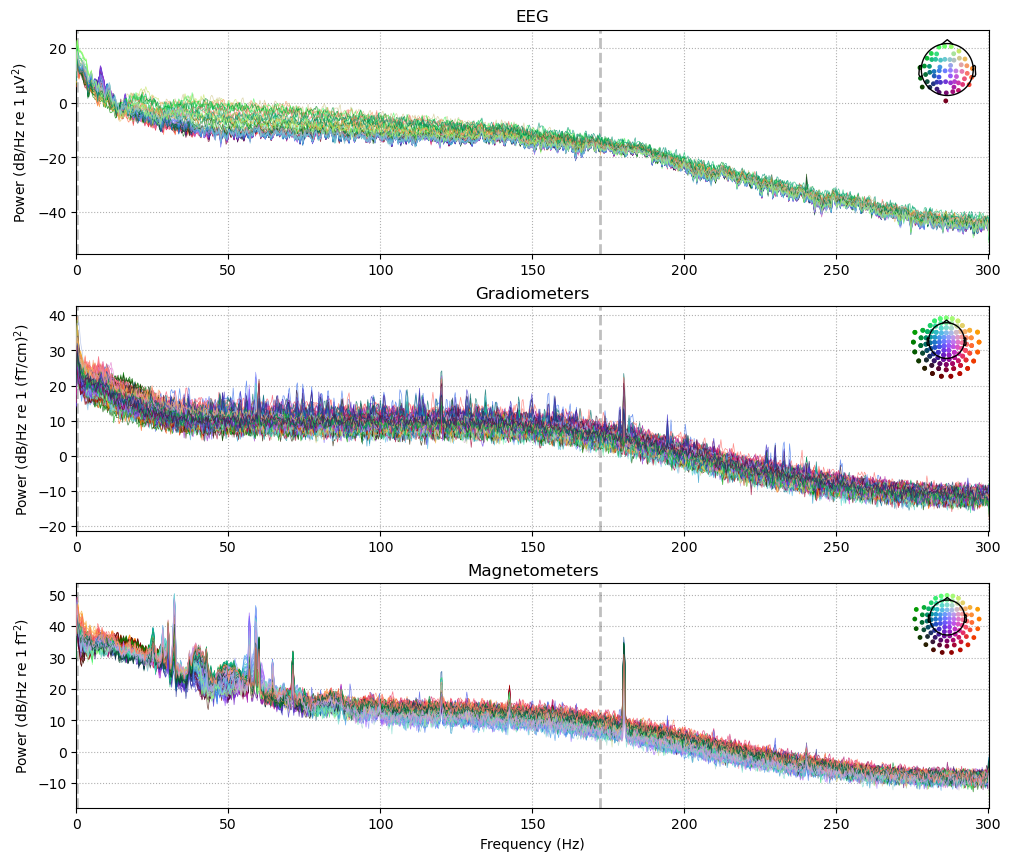

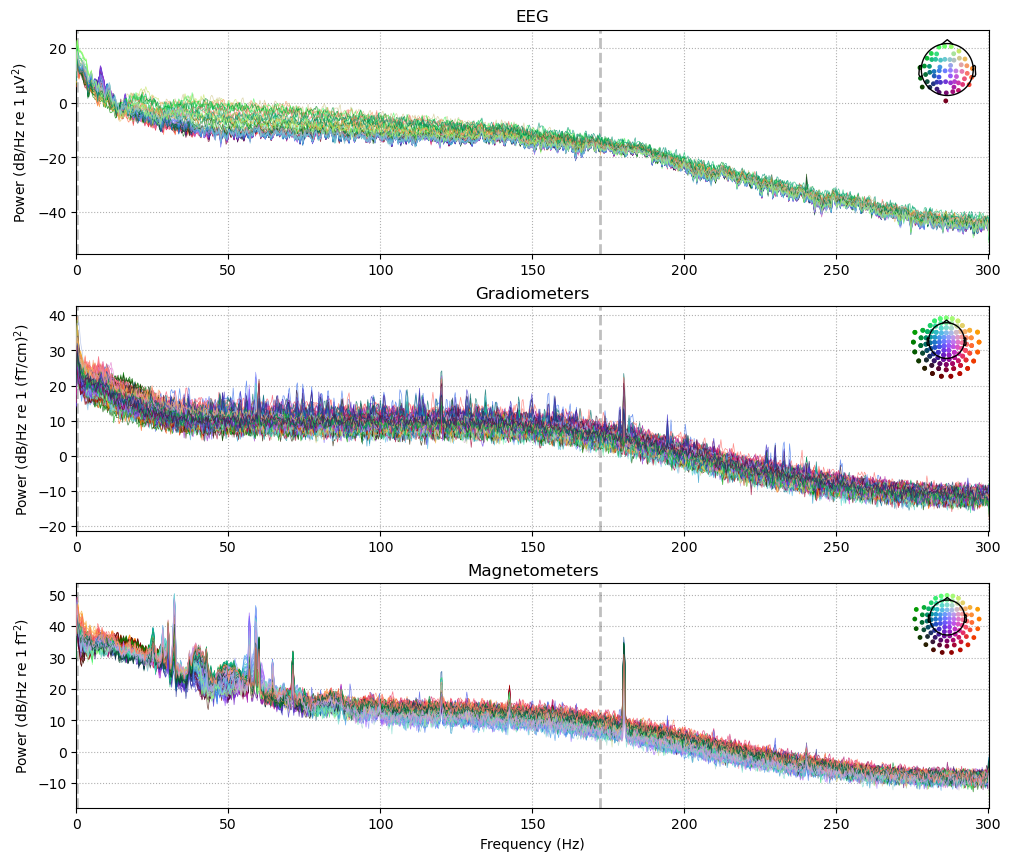

In [2]:
print(raw)
print(raw.info)
#可视化
#raw.plot()

#功率谱密度（PSD）图
raw.plot_psd()

# preprocessing
## 先进行伪迹的检测



In [3]:
# 低频漂移检测
mag_channels = mne.pick_types(raw.info, meg="mag")
#raw.plot(duration=60, order=mag_channels, n_channels=len(mag_channels), remove_dc=False)


In [4]:
# 工频伪迹检测
fig = raw.compute_psd(tmax=np.inf, fmax=250).plot(
    average=True, amplitude=False, picks="data", exclude="bads"
)
# add some arrows at 60 Hz and its harmonics:
for ax in fig.axes[1:]:
    freqs = ax.lines[-1].get_xdata()
    psds = ax.lines[-1].get_ydata()
    for freq in (60, 120, 180, 240):
        idx = np.searchsorted(freqs, freq)
        ax.arrow(
            x=freqs[idx],
            y=psds[idx] + 18,
            dx=0,
            dy=-12,
            color="red",
            width=0.1,
            head_width=3,
            length_includes_head=True,
        )

Effective window size : 3.410 (s)
Plotting power spectral density (dB=True).


D:\anaconda\envs\eeg-mne\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Reconstructing ECG signal from Magnetometers
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 6007 samples (10.001 s)

Number of ECG events detected : 59 (average pulse 58.9981981638739 / min.)
Not setting metadata
59 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 3)
Using data from preloaded Raw for 59 events and 601 original time points ...
0 bad epochs dropped
Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
59 matching events found
No baseline correct

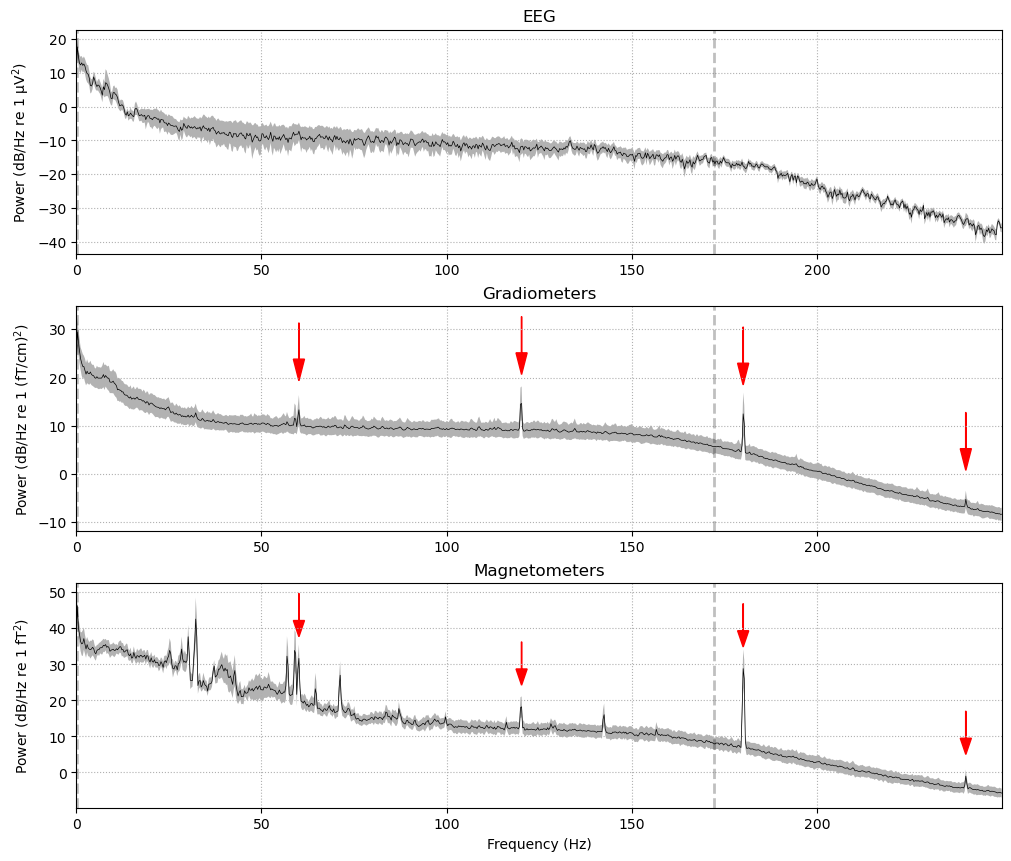

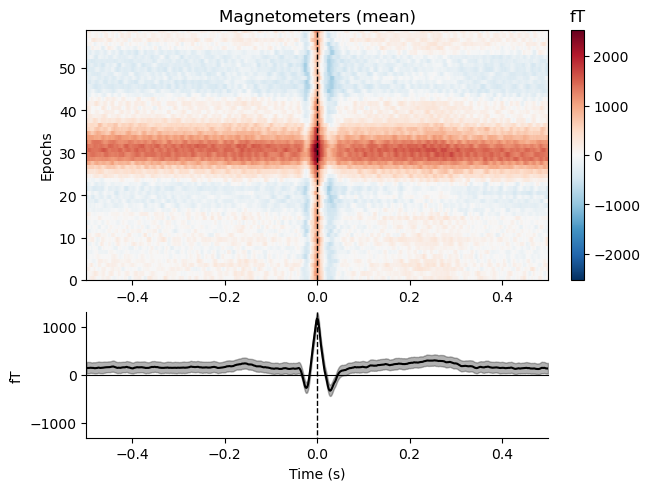

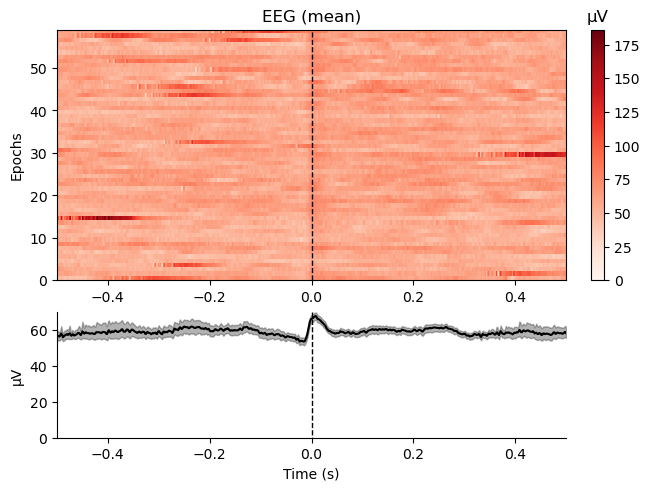

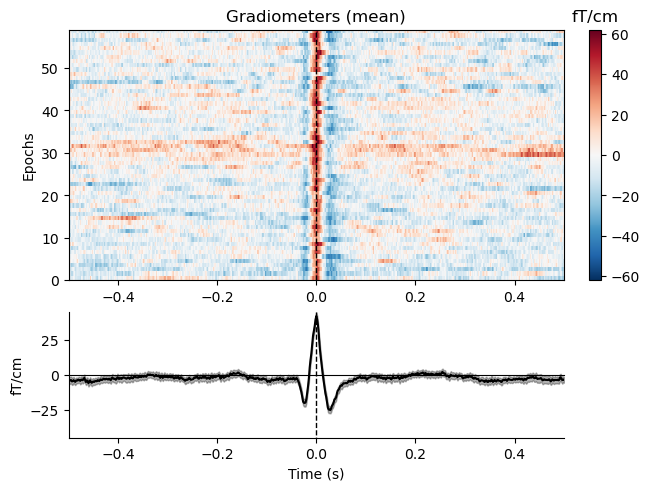

Applying baseline correction (mode: mean)


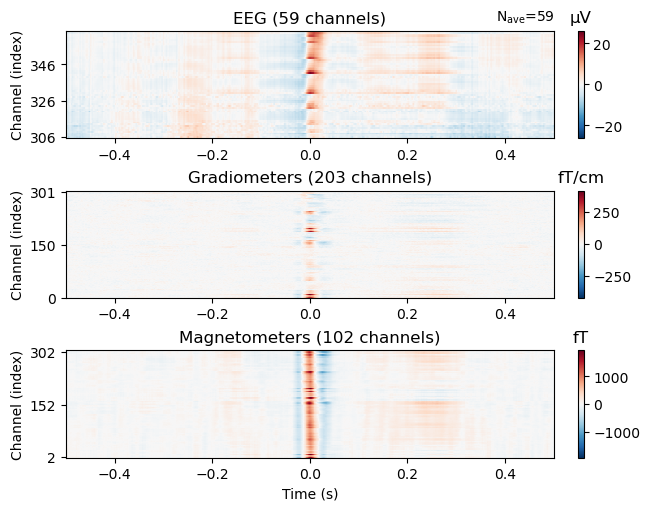

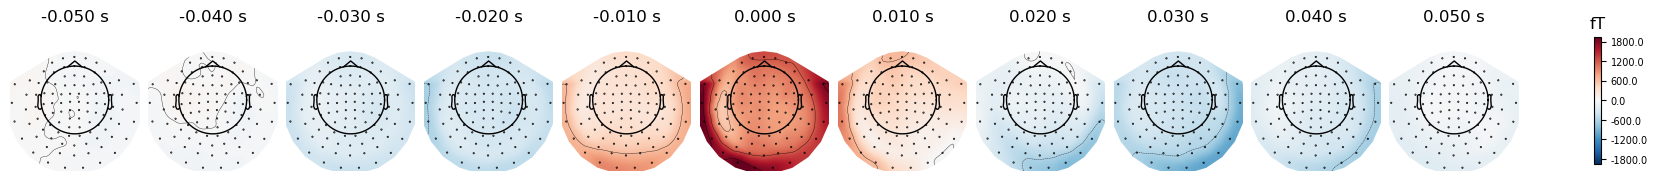

Created an SSP operator (subspace dimension = 3)
3 projection items activated
SSP projectors applied...


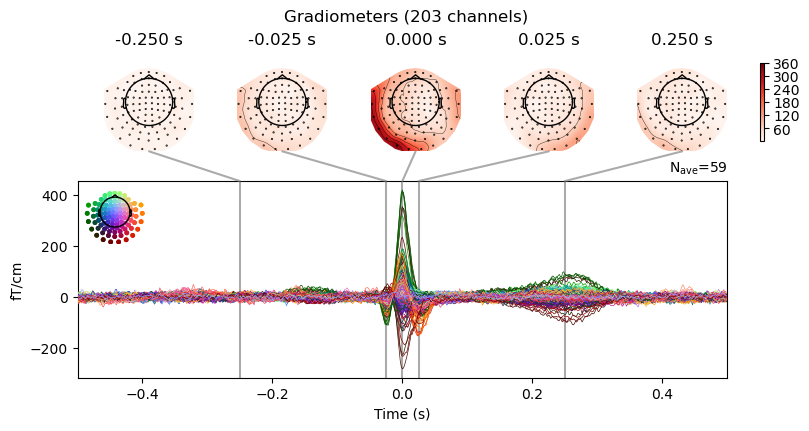

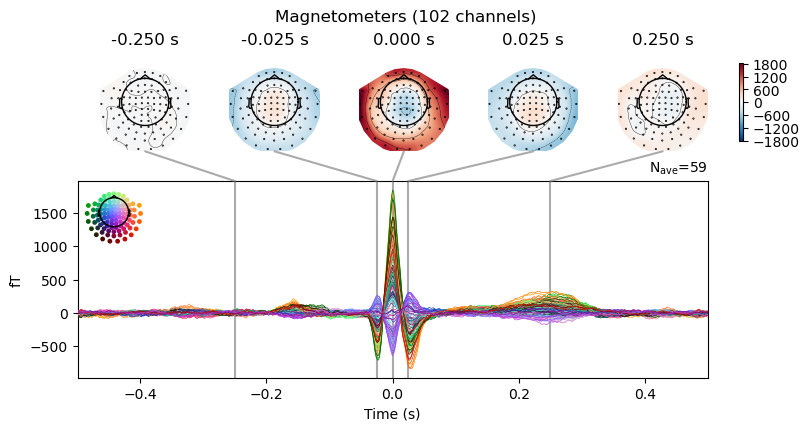

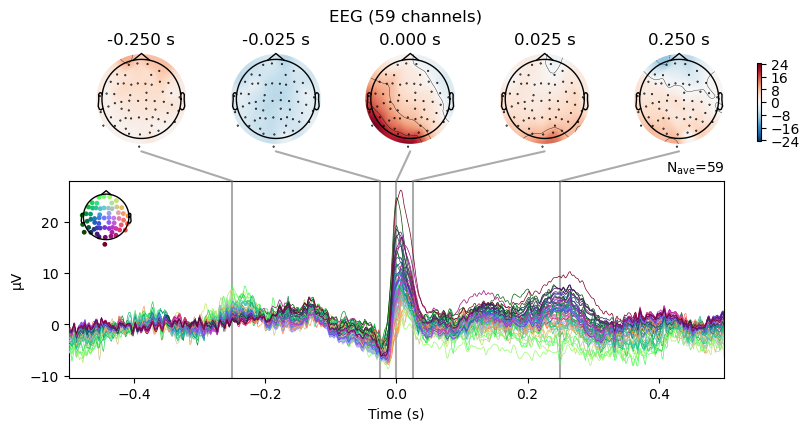

[<Figure size 800x420 with 8 Axes>,
 <Figure size 800x420 with 8 Axes>,
 <Figure size 800x420 with 8 Axes>]

In [5]:
# ECG检测
ecg_epochs = mne.preprocessing.create_ecg_epochs(raw)
ecg_epochs.plot_image(combine="mean")
avg_ecg_epochs = ecg_epochs.average().apply_baseline((-0.5, -0.2))
avg_ecg_epochs.plot_image()
avg_ecg_epochs.plot_topomap(times=np.linspace(-0.05, 0.05, 11))
avg_ecg_epochs.plot_joint(times=[-0.25, -0.025, 0, 0.025, 0.25])

Using EOG channel: EOG 061
EOG channel index for this subject is: [375]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOG 061 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 6007 samples (10.001 s)

Now detecting blinks and generating corresponding events
Found 10 significant peaks
Number of EOG events detected: 10
Not setting metadata
10 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
Using data from preloaded Raw for 10 events and 601 original t

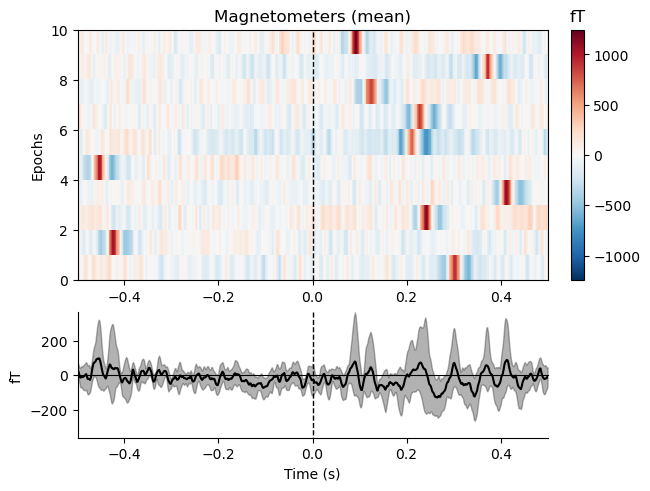

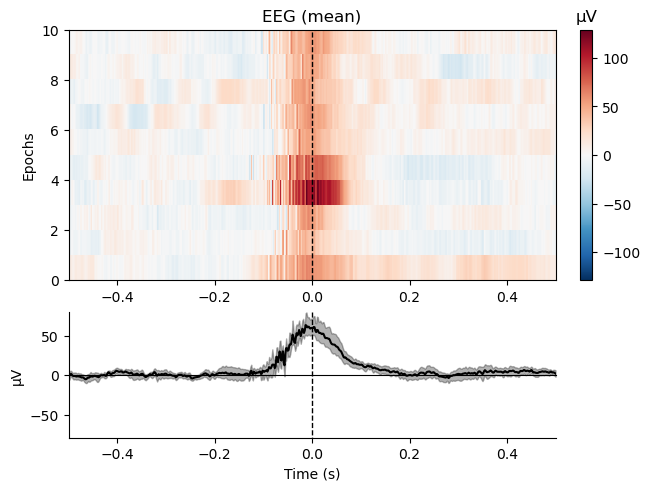

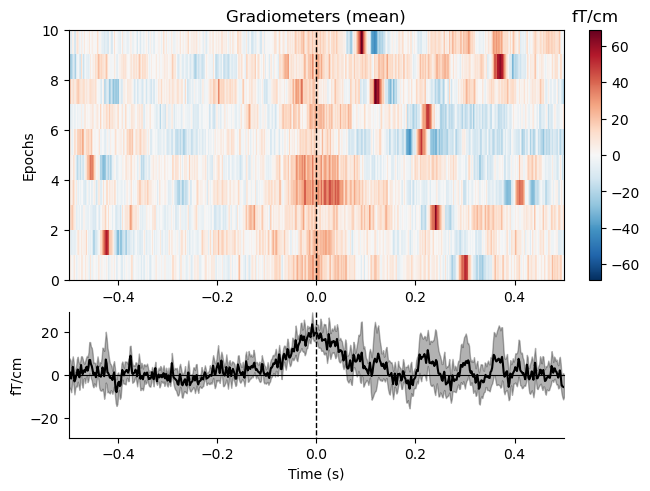

Created an SSP operator (subspace dimension = 3)
3 projection items activated
SSP projectors applied...


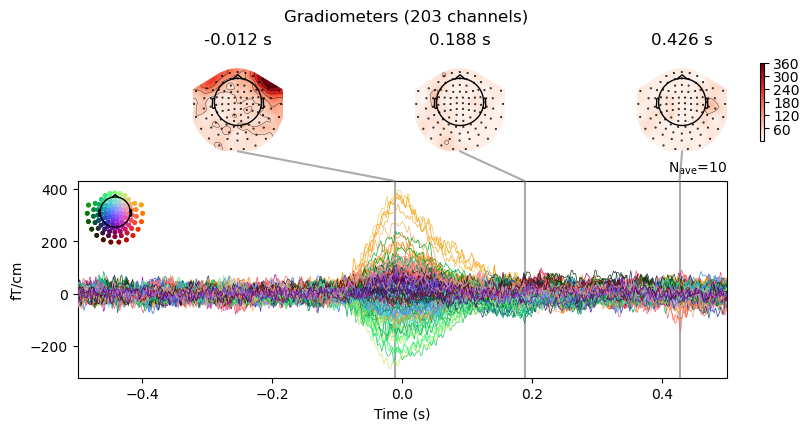

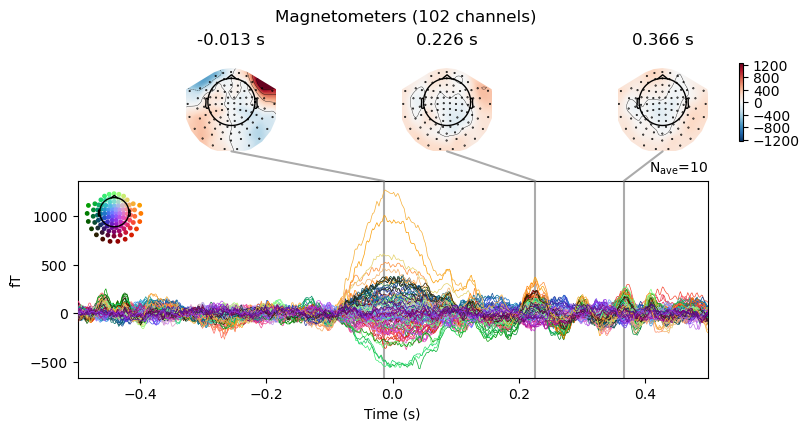

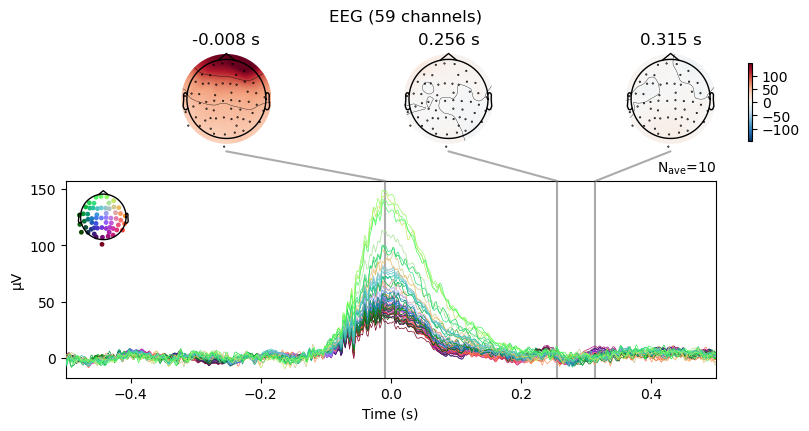

[<Figure size 800x420 with 6 Axes>,
 <Figure size 800x420 with 6 Axes>,
 <Figure size 800x420 with 6 Axes>]

In [6]:
#眼动伪迹检测
eog_epochs = mne.preprocessing.create_eog_epochs(raw, baseline=(-0.5, -0.2))
eog_epochs.plot_image(combine="mean")
eog_epochs.average().plot_joint()

## 坏导处理

In [7]:
# 插值坏导
print(raw.info["bads"])
raw_interp = raw.interpolate_bads(reset_bads=True)
## 插值后检查
print(raw.info["bads"])
#raw.plot()



['MEG 2443', 'EEG 053']
Setting channel interpolation method to {'eeg': 'spline', 'meg': 'MNE'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 91.2 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 1 sensors
    Computing dot products for 305 MEG channels...
    Computing cross products for 305 → 1 MEG channel...
    Preparing the mapping matrix...
    Truncating at 85/305 components to omit less than 0.0001 (9.4e-05)
[]


## 滤波和降采样

In [8]:
#notch filter 
def add_arrows(axes):
    """Add some arrows at 60 Hz and its harmonics."""
    for ax in axes:
        freqs = ax.lines[-1].get_xdata()
        psds = ax.lines[-1].get_ydata()
        for freq in (60, 120, 180, 240):
            idx = np.searchsorted(freqs, freq)
            # get ymax of a small region around the freq. of interest
            y = psds[(idx - 4) : (idx + 5)].max()
            ax.arrow(
                x=freqs[idx],
                y=y + 18,
                dx=0,
                dy=-12,
                color="red",
                width=0.1,
                head_width=3,
                length_includes_head=True,
            )
fig = raw.compute_psd(fmax=250).plot(
    average=True, amplitude=False, picks="data", exclude="bads"
)
add_arrows(fig.axes[:2])



Effective window size : 3.410 (s)
Plotting power spectral density (dB=True).


D:\anaconda\envs\eeg-mne\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


In [9]:


meg_picks = mne.pick_types(raw.info, meg=True)
freqs = (60, 120, 180, 240)
raw_notch = raw.notch_filter(freqs=freqs, picks=meg_picks)
for title, data in zip(["Un", "Notch "], [raw, raw_notch]):
    fig = data.compute_psd(fmax=250).plot(
        average=True, amplitude=False, picks="data", exclude="bads"
    )
    fig.suptitle(f"{title}filtered", size="xx-large", weight="bold")
    add_arrows(fig.axes[:2])

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3965 samples (6.602 s)

Effective window size : 3.410 (s)
Plotting power spectral density (dB=True).


D:\anaconda\envs\eeg-mne\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Effective window size : 3.410 (s)
Plotting power spectral density (dB=True).


D:\anaconda\envs\eeg-mne\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 9911 samples (16.501 s)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 3.410 (s)
Plotting power spectral density (dB=True).


D:\anaconda\envs\eeg-mne\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


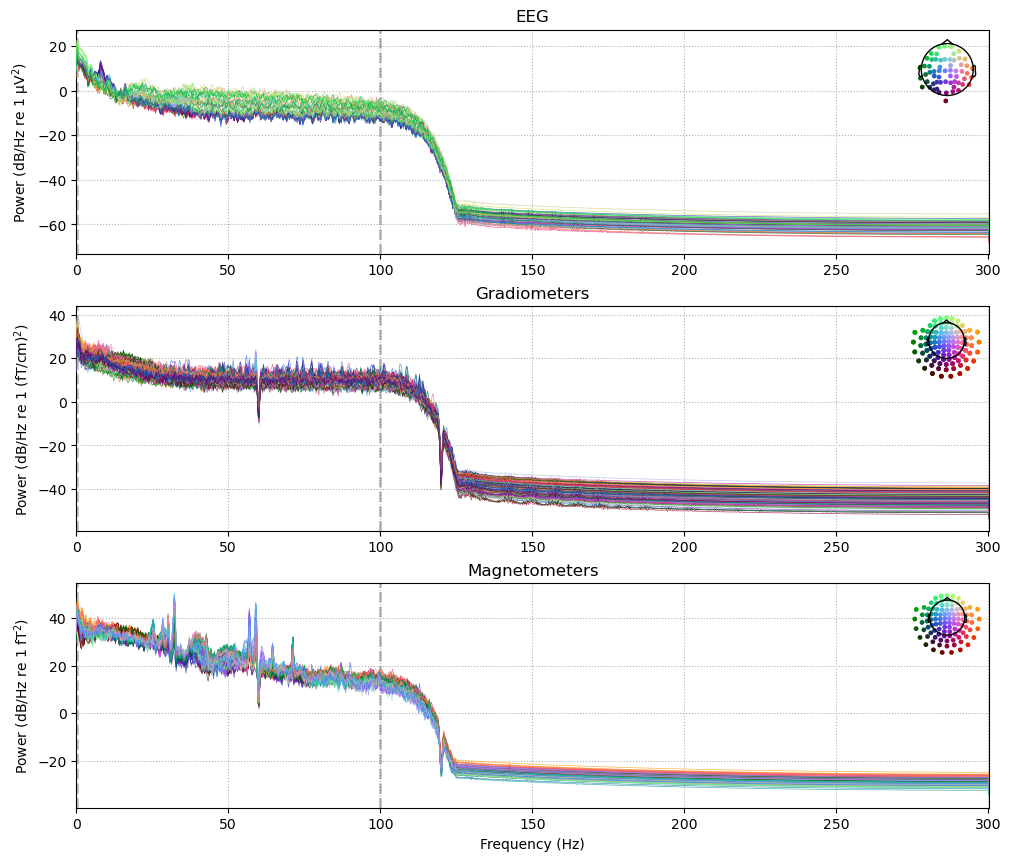

In [10]:
#filter 
picks = mne.pick_types(raw.info, meg='mag', eeg=False, eog=False,
                       stim=False, exclude='bads')
raw.filter(0.2,100) 
raw.plot_psd()


Finding events on: STI 014
86 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]
Polyphase resampling neighborhood: ±2 input samples
Finding events on: STI 014
86 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 6.820 (s)
Plotting power spectral density (dB=True).


D:\anaconda\envs\eeg-mne\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


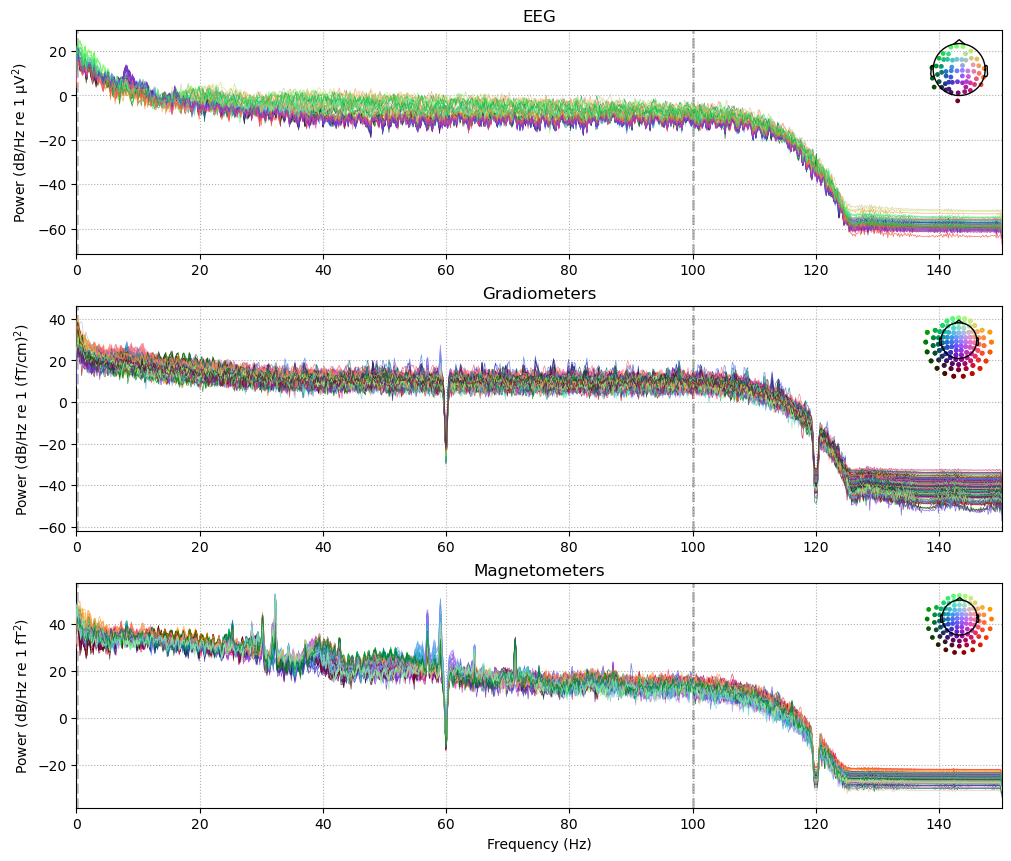

In [11]:
#resample 
n_ffts = [4096, 2048]  # factor of 2 smaller n_fft
raw_downsampled_poly = raw.resample(
    sfreq=raw.info["sfreq"] / 2.0,
    method="polyphase",
    verbose=True,
)
raw.plot_psd()

# ICA

In [12]:
from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs
print(raw.info["bads"])
#通道选择

# EEG 的 ICA
picks_eeg = mne.pick_types(raw.info,
                           meg=False, eeg=True,
                           eog=False, ecg=False, stim=False)

# MEG（mag+grad 都要）的 ICA
picks_meg = mne.pick_types(raw.info,
                           meg=True,  # 包含 mag 和 grad
                           eeg=False,
                           eog=False, ecg=False, stim=False)

ica = ICA(
    n_components=25,      # 经验：EEG 20–40；MEG 可略多。也可设 n_components='auto'
    method='fastica',     # 常见：'fastica'、'picard'、'infomax'
    random_state=97
)

# 使用 decim 抽样加速；reject 可加简单阈值避免极端噪声影响 ICA 学习
ica.fit(raw, picks=picks_eeg, decim=3, reject={'eeg': 200e-6})


[]
Fitting ICA to data using 60 channels (please be patient, this may take a while)
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006', 'EEG 007']
Artifact detected in [1407, 1608]
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 007']
Artifact detected in [3015, 3216]
Selecting by number: 25 components
Fitting ICA took 0.6s.


<ICA | raw data decomposition, method: fastica (fit in 76 iterations on 5427 samples), 25 ICA components (60 PCA components available), channel types: eeg, no sources marked for exclusion>

## 识别伪迹对应的IC

Using EOG channel: EOG 061
EOG channel index for this subject is: [375]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOG 061 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 3004 samples (10.003 s)

Now detecting blinks and generating corresponding events
Found 10 significant peaks
Number of EOG events detected: 10
Not setting metadata
10 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 3)
Using data from preloaded Raw for 10 events and 301 original time points 

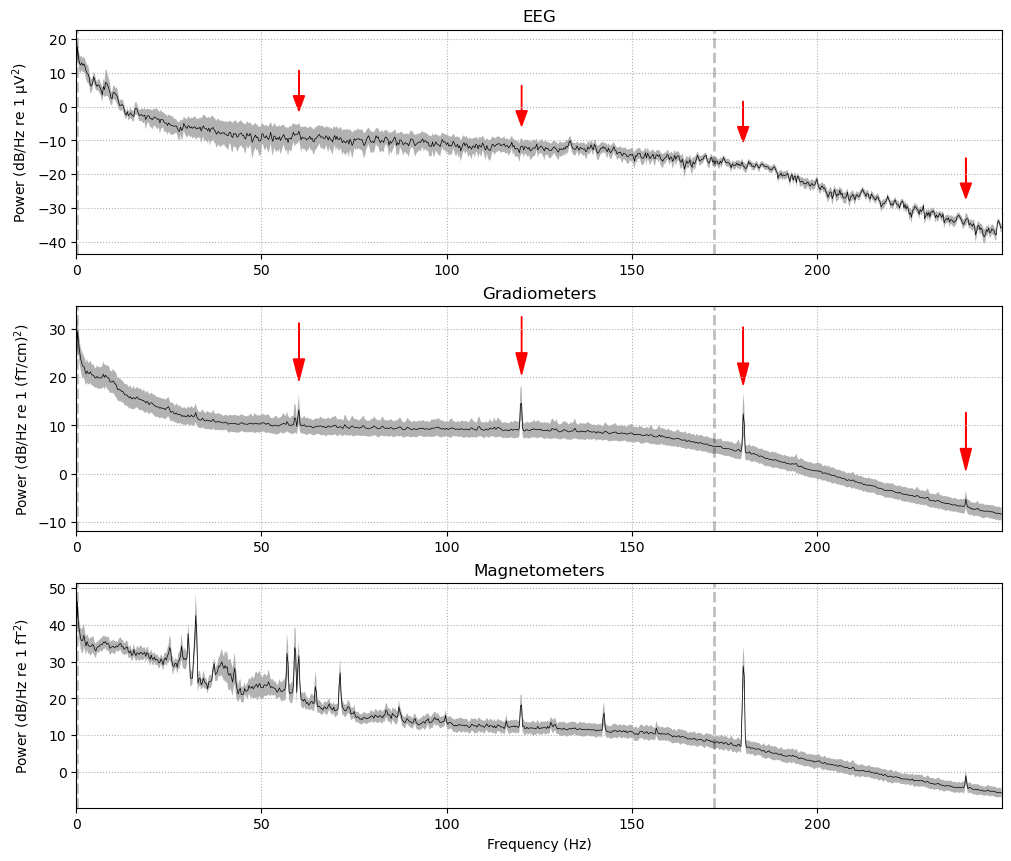

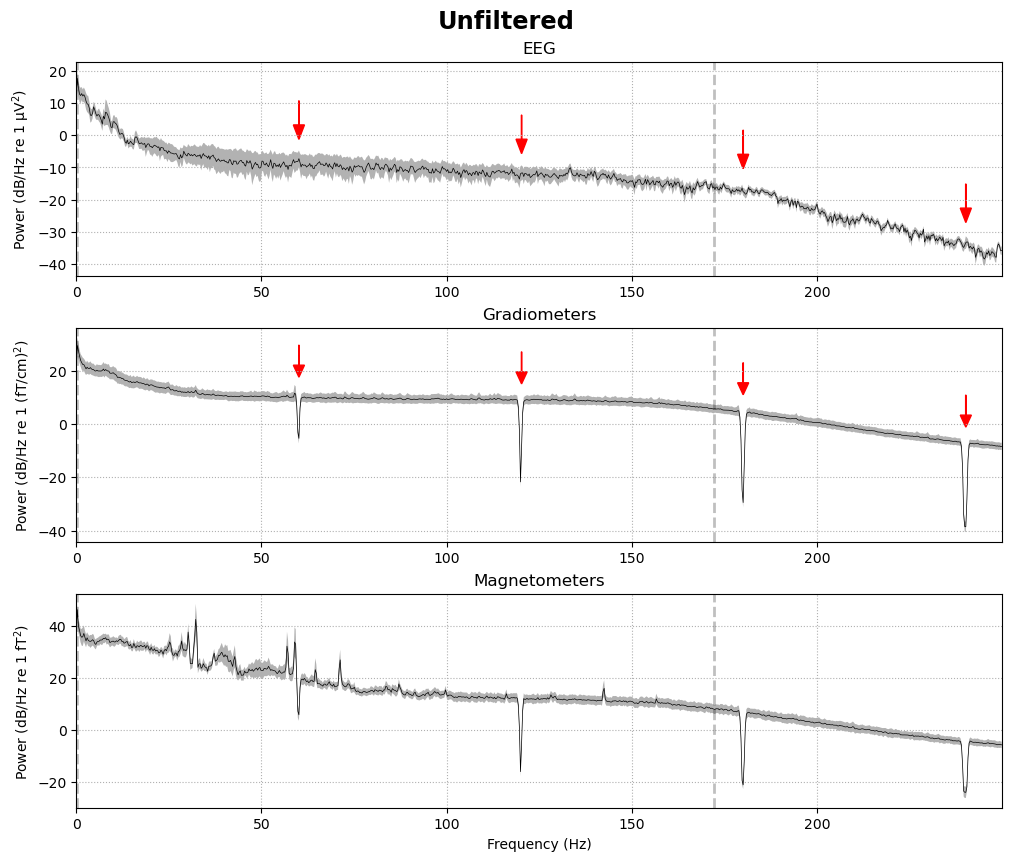

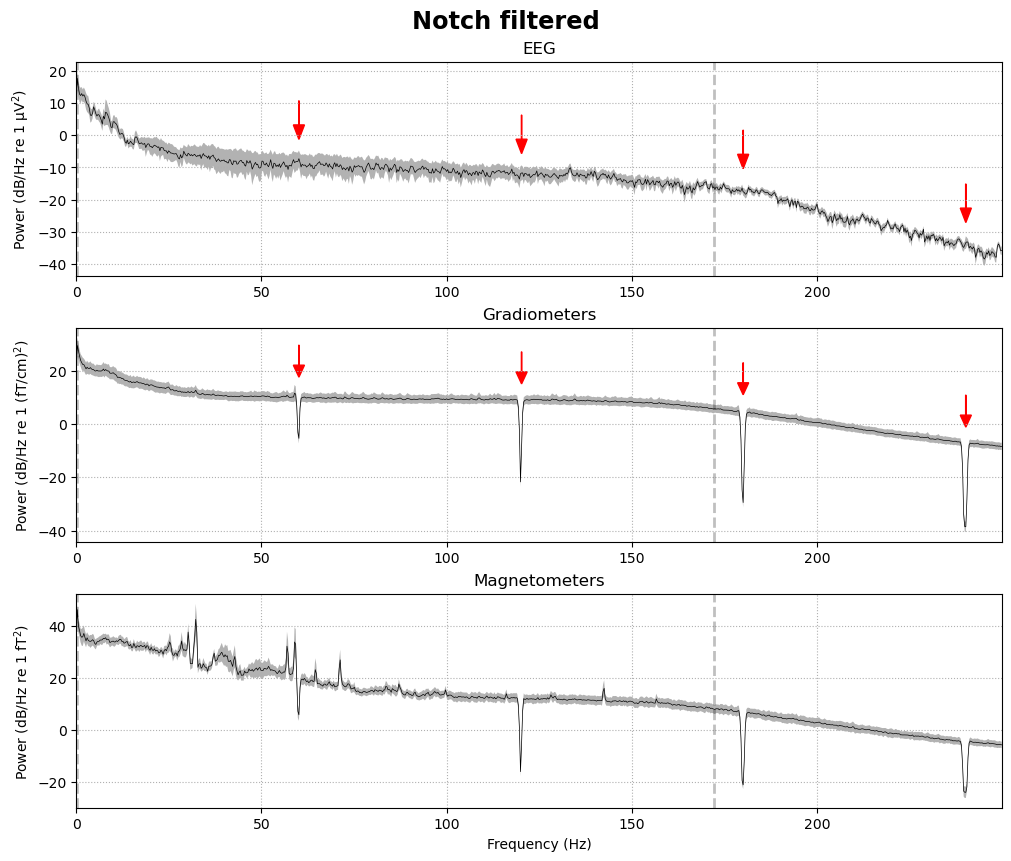

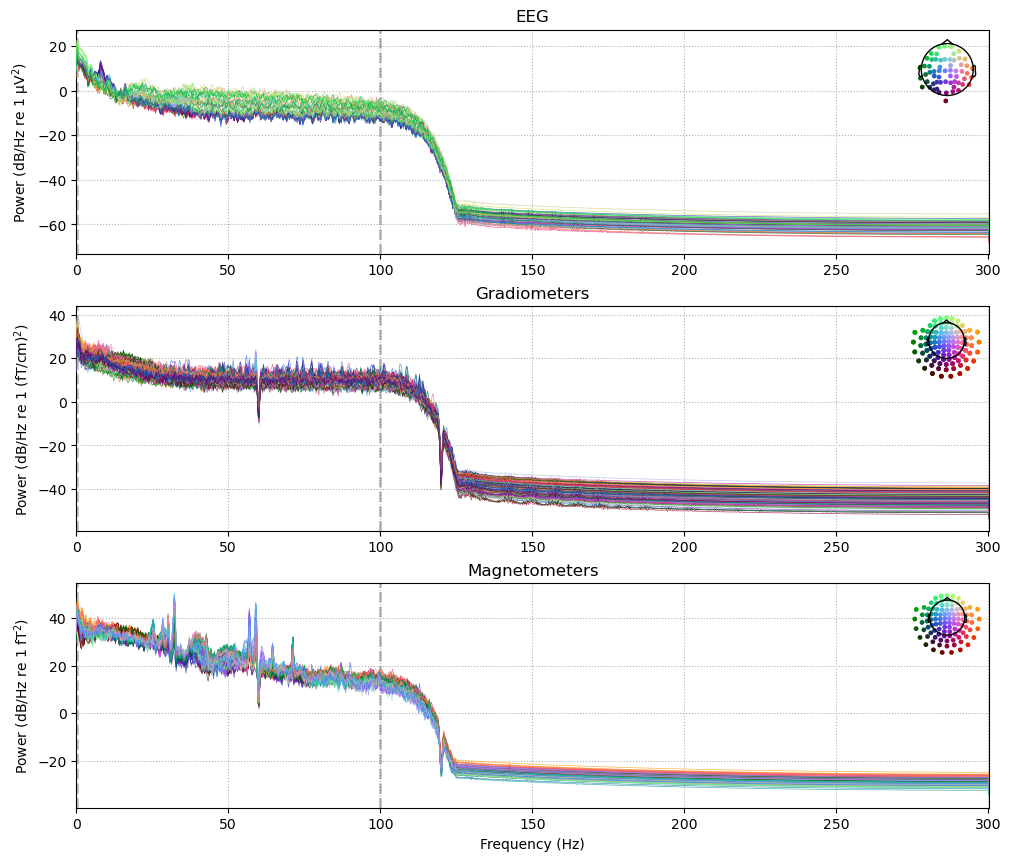

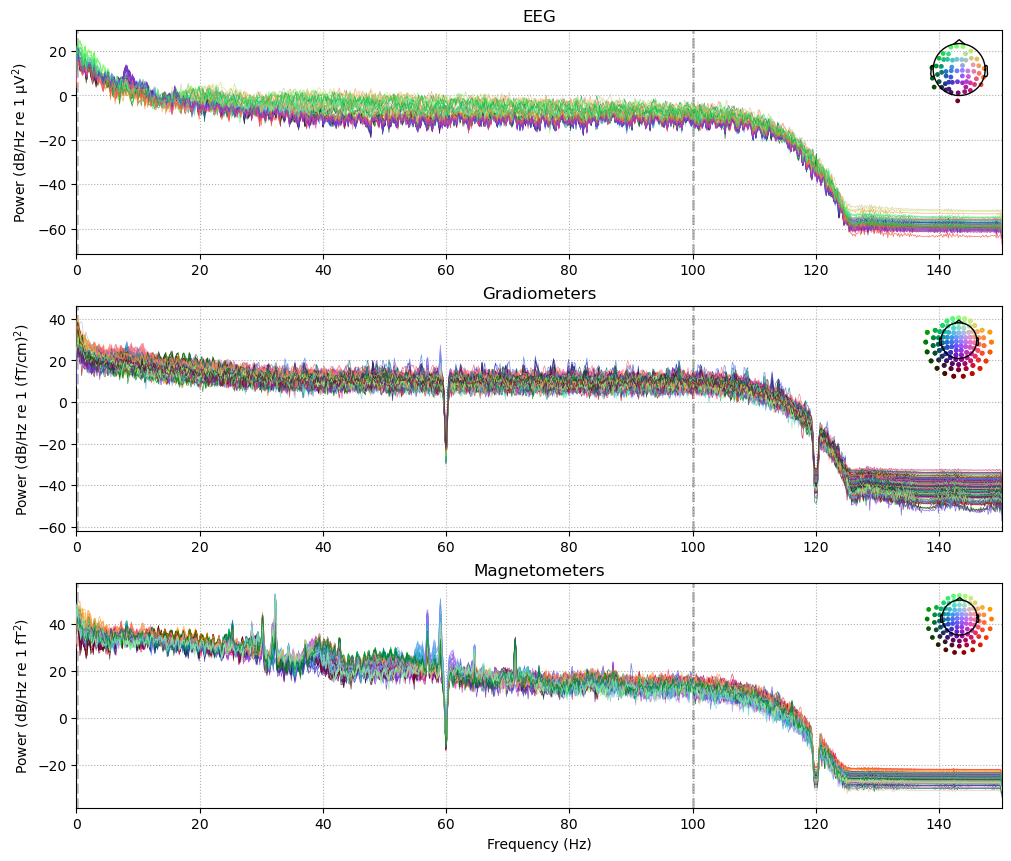

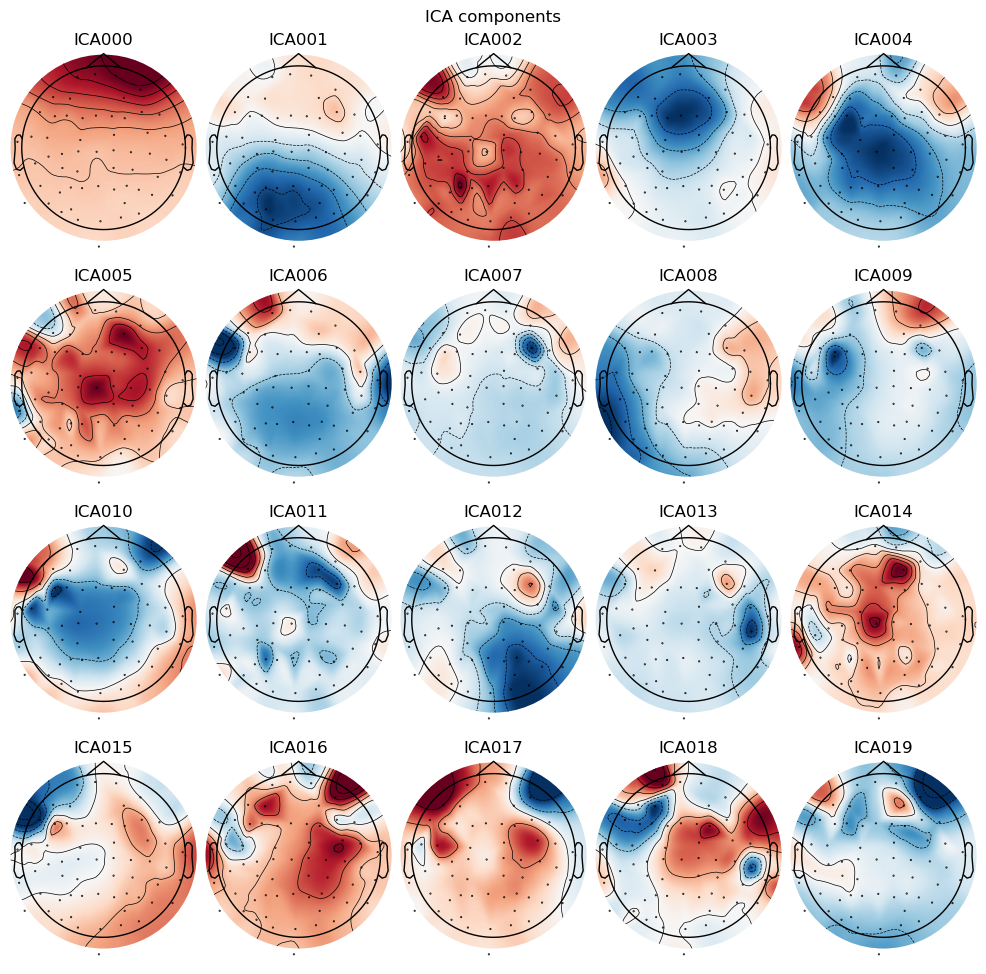

Creating RawArray with float64 data, n_channels=26, n_times=18019
    Range : 12900 ... 30918 =     42.956 ...   102.954 secs
Ready.
Using qt as 2D backend.


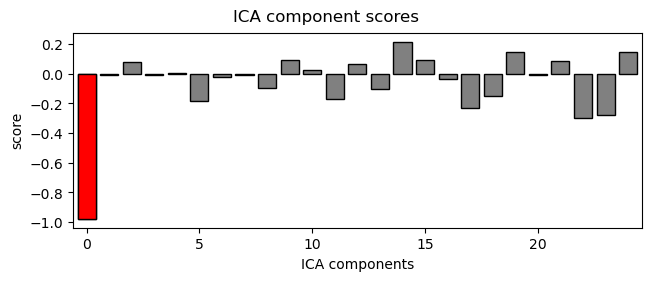

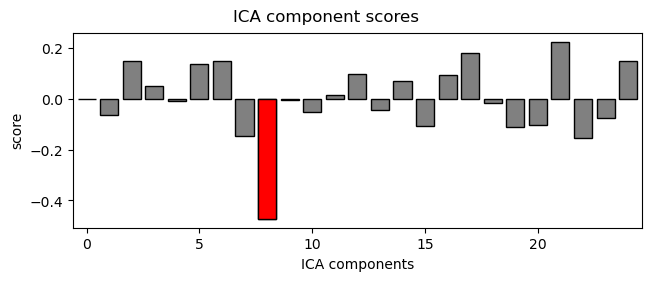

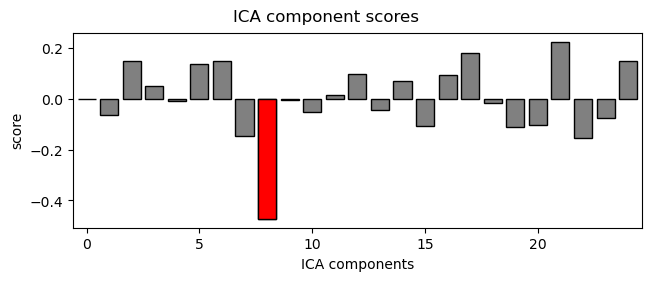

In [13]:

#EOG（眨眼/眼动）
eog_epochs = create_eog_epochs(raw)              # 自动找眨眼事件并切 epoch
eog_inds, eog_scores = ica.find_bads_eog(raw)    # 或传 eog_epochs
# eog_inds 是可疑成分的索引列表
print("EOG-like ICs:", eog_inds)

# ECG（心跳）
ecg_epochs = create_ecg_epochs(raw)
ecg_inds, ecg_scores = ica.find_bads_ecg(raw, method='correlation')
print("ECG-like ICs:", ecg_inds)

# 可视化核对
ica.plot_components(picks=range(0, 20))           # 成分拓扑（空间分布）
ica.plot_sources(raw, start=0, stop=30)      # 成分时序（叠加）
ica.plot_scores(eog_scores, exclude=eog_inds)     # 与 EOG 的相关性得分
ica.plot_scores(ecg_scores, exclude=ecg_inds)     # 与 ECG 的相关性得分



## 去除伪迹成分

Will exclude ICs: [np.int64(0), np.int64(8)]
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 2 ICA components
    Projecting back using 60 PCA components


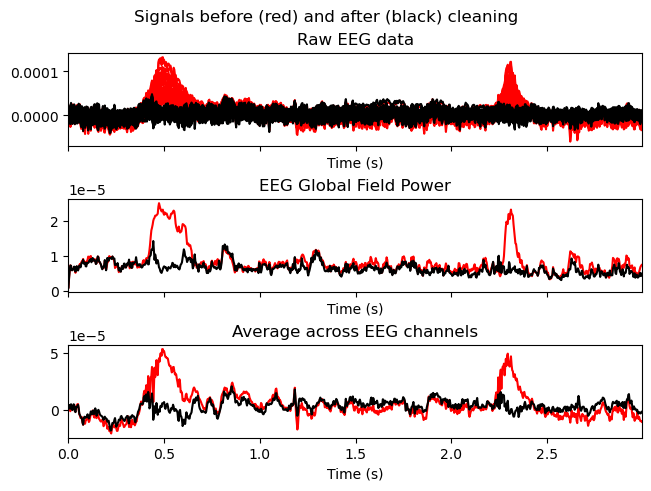

[np.int64(0), np.int64(8)]
[np.int64(0), np.int64(8)]
Applying ICA to Raw instance
    Transforming to ICA space (25 components)
    Zeroing out 2 ICA components
    Projecting back using 60 PCA components


<Raw | sample_audvis_raw.fif, 376 x 18019 (60.0 s), ~54.9 MiB, data loaded>

In [15]:
#  汇总要剔除的成分索引
to_exclude = list(set(eog_inds) | set(ecg_inds))
ica.exclude = to_exclude
print("Will exclude ICs:", ica.exclude)

# 预览（红=原始，黑=去除后重构）
ica.plot_overlay(raw, exclude=ica.exclude, picks='eeg')   # 或 'meg'
print(ica.exclude)
#查看ICA效果
print(ica.exclude)
raw_orig=raw.copy()
ica.apply(raw) 
#raw_orig.plot()
#raw.plot()

# 识别试验事件

In [16]:
events = mne.find_events(raw,stim_channel="STI 014")
print(events[:5]) 

Finding events on: STI 014
86 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]
[[13988     0     2]
 [14172     0     3]
 [14385     0     1]
 [14609     0     4]
 [14826     0     2]]


In [17]:
# 根据实验设计编写事件字典
event_dict = {
    "auditory/left": 1,
    "auditory/right": 2,
    "visual/left": 3,
    "visual/right": 4,
    "smiley": 5,
    "buttonpress": 32,
}


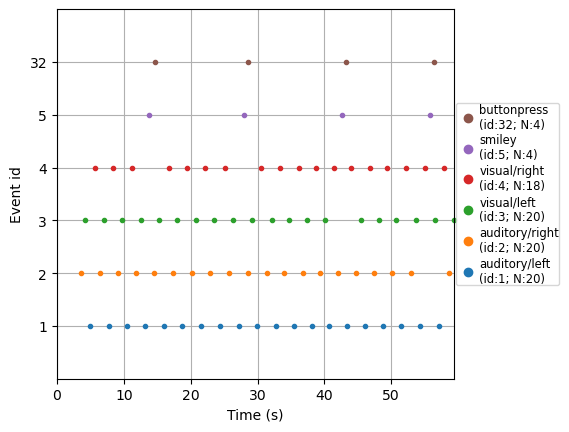

In [18]:
# 绘制事件分布图
fig = mne.viz.plot_events(
    events, event_id=event_dict, sfreq=raw.info["sfreq"], first_samp=raw.first_samp
)

## Epoching continuous data 


In [19]:
reject_criteria = dict(
    mag=4000e-15,  # 4000 fT
    grad=4000e-13,  # 4000 fT/cm
    eeg=150e-6,  # 150 µV
    eog=250e-6,
)  # 250 µV

epochs=mne.Epochs(
    raw,
    events,
    event_id=event_dict,
    tmin=-0.2,
    tmax= 0.5,
    reject=reject_criteria,
    preload=True
)



Not setting metadata
86 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
3 projection items activated
Using data from preloaded Raw for 86 events and 211 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
2 bad epochs dropped


In [20]:

conds_we_care_about=["auditory/left","auditory/right","visual/left","visual/right"]
epochs.equalize_event_counts(conds_we_care_about) 
aud_epochs=epochs["auditory"]
vis_epochs=epochs["visual"]
del raw,epochs


Dropped 8 epochs: 0, 1, 14, 17, 34, 37, 38, 39


Not setting metadata
34 matching events found
No baseline correction applied
0 projection items activated


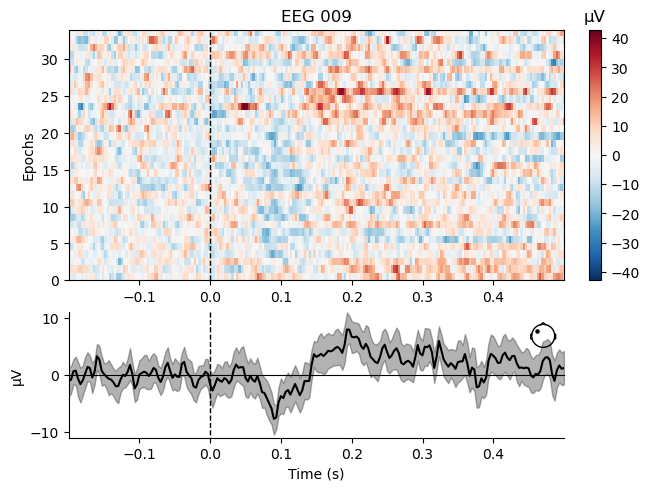

[<Figure size 640x480 with 4 Axes>]

In [21]:
aud_epochs.plot_image(picks=["EEG 009"])

No baseline correction applied


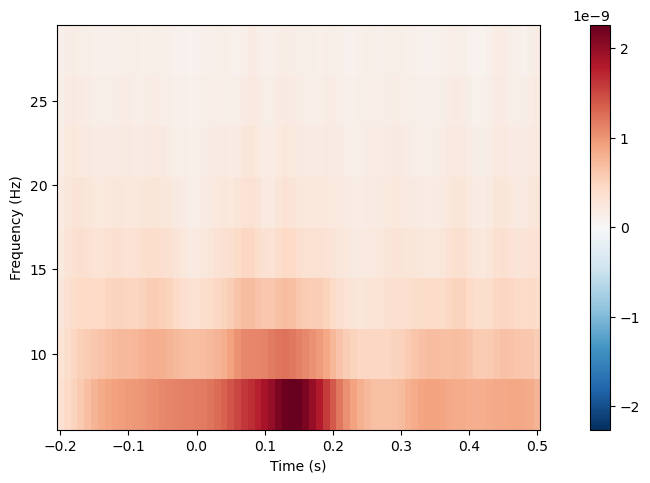

[<Figure size 640x480 with 2 Axes>]

In [22]:
frequencies=np.arange(7,30,3)
power=aud_epochs.compute_tfr(
    "morlet",n_cycles=2,return_itc=False,freqs=frequencies,decim=3,average=True
)
power.plot(["EEG 021"])


# evoked

combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


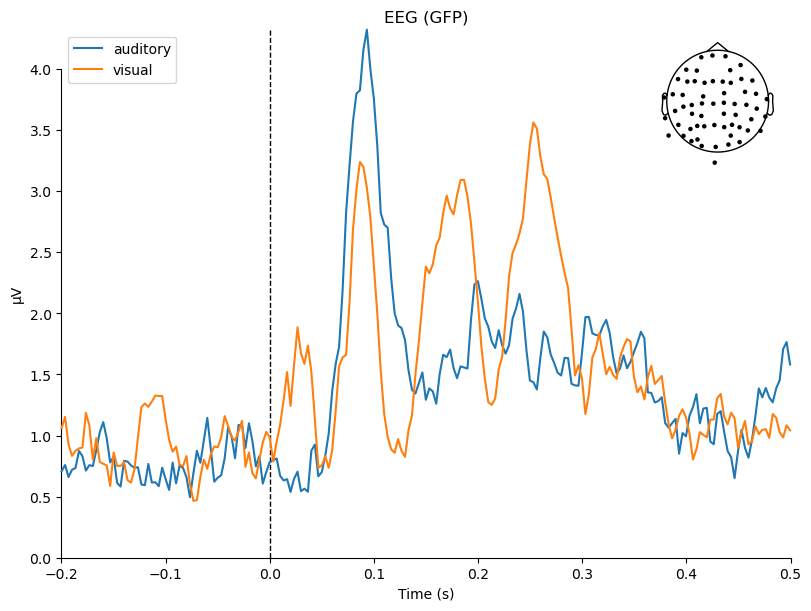

[<Figure size 800x600 with 2 Axes>]

In [23]:
aud_evoked = aud_epochs.average()
vis_evoked = vis_epochs.average()

mne.viz.plot_compare_evokeds(
    dict(auditory=aud_evoked, visual=vis_evoked),
    legend="upper left",
    show_sensors="upper right",
    picks="eeg"
)

Projections have already been applied. Setting proj attribute to True.


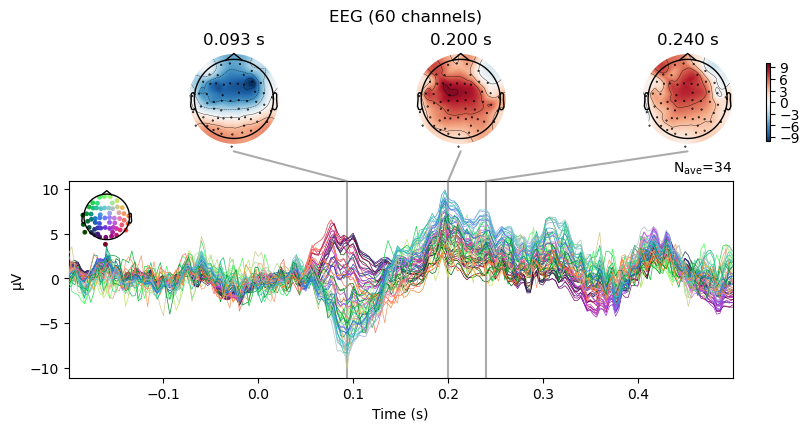

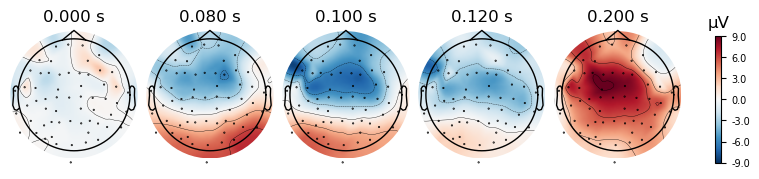

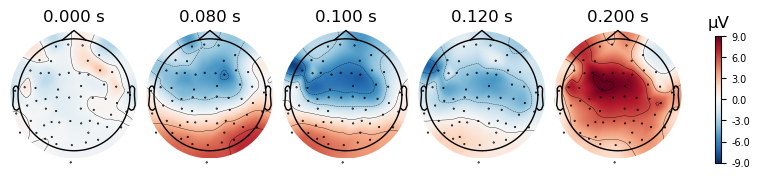

In [24]:
aud_evoked.plot_joint(picks="eeg")
aud_evoked.plot_topomap(times=[0.0, 0.08, 0.1, 0.12, 0.2], ch_type="eeg")

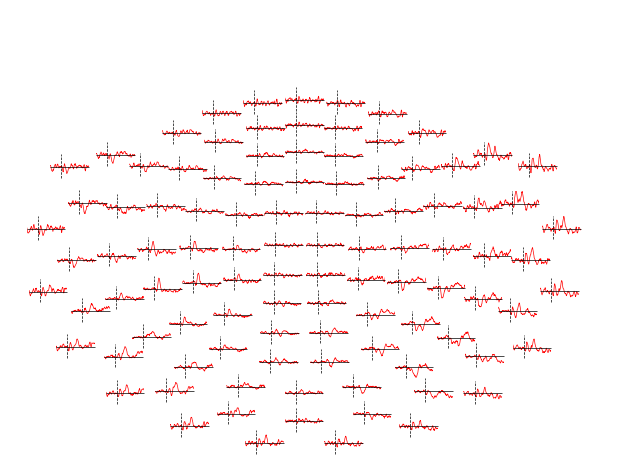

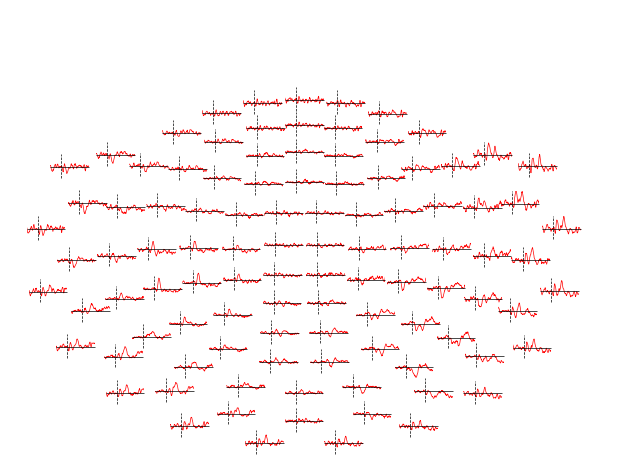

In [25]:
#查看组间对比
evoked_diff = mne.combine_evoked([aud_evoked, vis_evoked], weights=[1, -1])
evoked_diff.pick(picks="mag").plot_topo(color="r", legend=False)

# 源定位分析

In [26]:
# load inverse operator
inverse_operator_file = (
    sample_data_folder / "MEG" / "sample" / "sample_audvis-meg-oct-6-meg-inv.fif"
)
inv_operator = mne.minimum_norm.read_inverse_operator(inverse_operator_file)
# set signal-to-noise ratio (SNR) to compute regularization parameter (λ²)
snr = 3.0
lambda2 = 1.0 / snr**2
# generate the source time course (STC)
stc = mne.minimum_norm.apply_inverse(
    vis_evoked, inv_operator, lambda2=lambda2, method="MNE"
)  # or dSPM, sLORETA, eLORETA

Reading inverse operator decomposition from D:\Download\常用学习\neuroscience\计算\dataset\MNE-sample-data\MNE-sample-data\MEG\sample\sample_audvis-meg-oct-6-meg-inv.fif...
    Reading inverse operator info...
    [done]
    Reading inverse operator decomposition...
    [done]
    305 x 305 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Noise covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 2) found.
    Source covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 6) found.
    Orientation priors read.
    22494 x 22494 diagonal covariance (kind = 5) found.
    Depth priors read.
    Did not find the desired covariance matrix (kind = 3)
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading

In [27]:
# path to subjects' MRI files
subjects_dir = sample_data_folder / "subjects"
# plot the STC
stc.plot(
    initial_time=0.1, hemi="split", views=["lat", "med"], subjects_dir=subjects_dir
)

Using control points [1.56897041e-10 1.83738544e-10 5.14262008e-10]


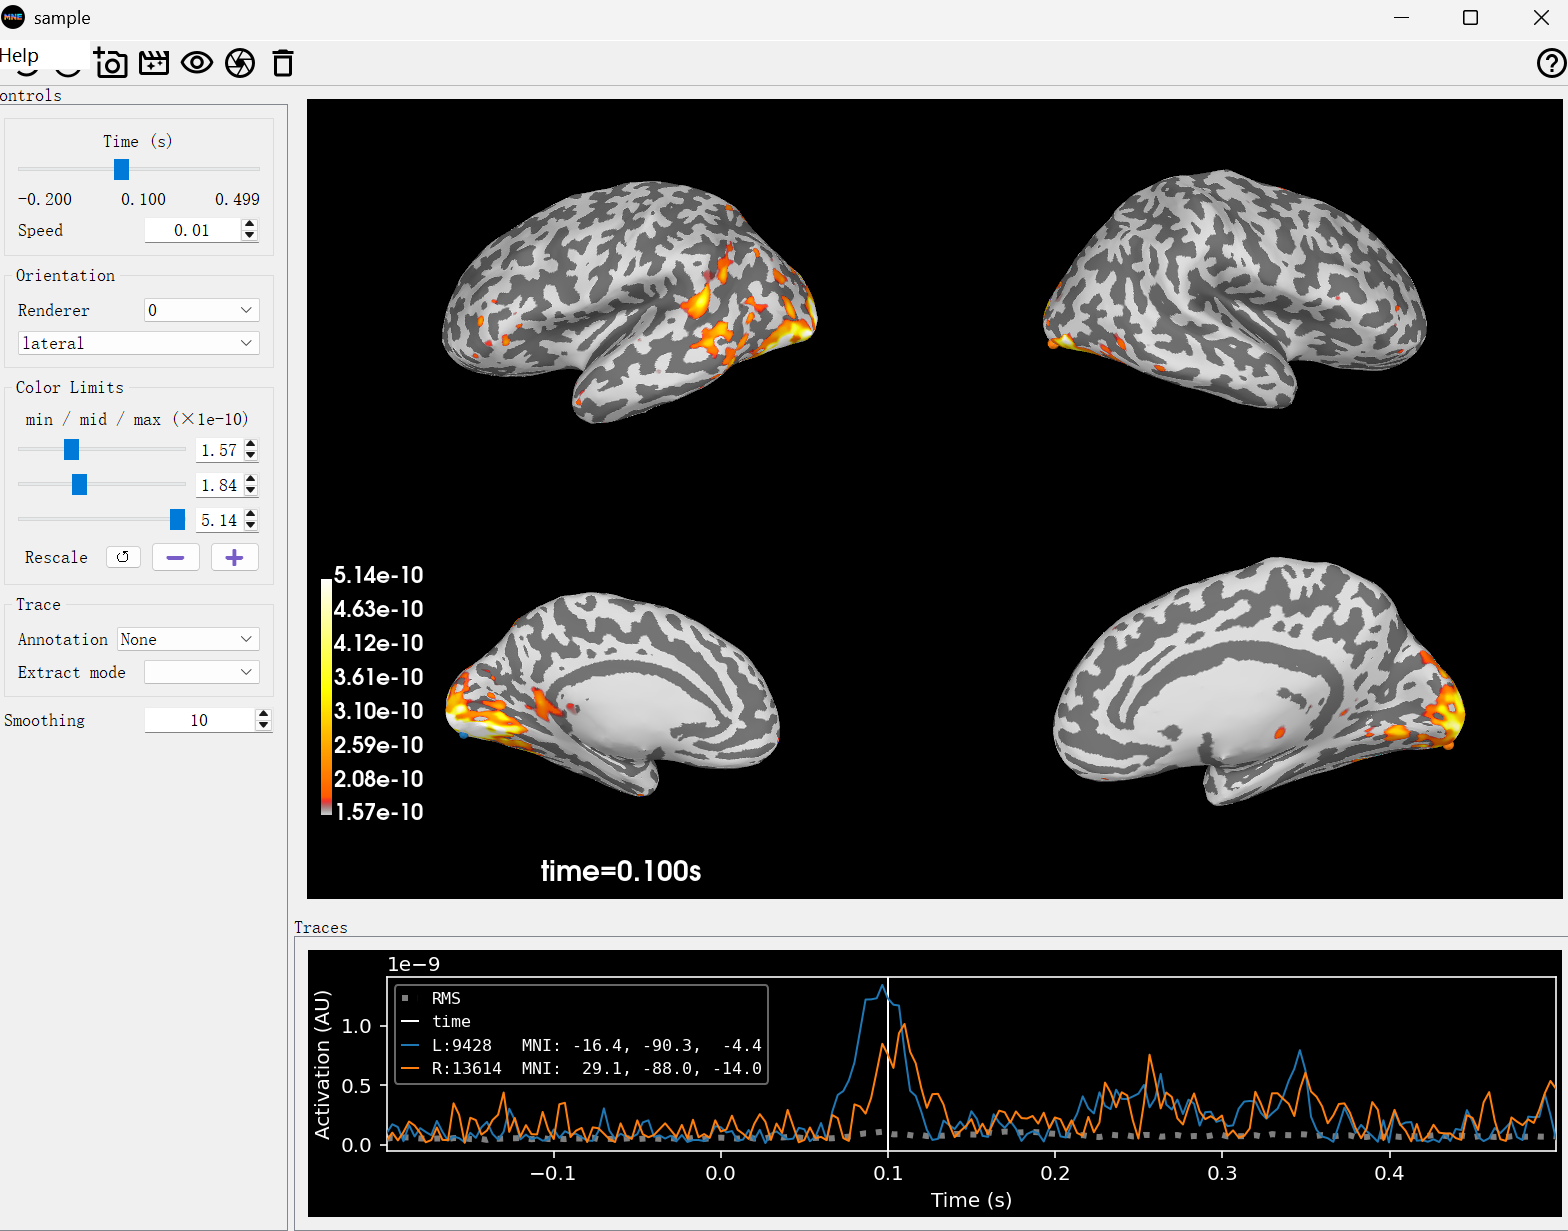